In [234]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy.stats import skew, kurtosis
from sklearn.feature_selection import mutual_info_classif, SelectKBest

#### Loading the data into dataframe

In [235]:
train_data = pd.read_csv("train.csv", header=None)
test_data = pd.read_csv("test.csv", header=None)

#dividing into label and timeseries
X_train = train_data.iloc[: , 1:].values
y_train = train_data.iloc[:, 0].values

X_test = test_data

print("X train shape: ", X_train.shape)
print("y train shape: ", y_train.shape)
print("X test shape: ", X_test.shape)
print("The classes in this dataset: ", np.unique(y_train))

X train shape:  (4999, 178)
y train shape:  (4999,)
X test shape:  (1000, 178)
The classes in this dataset:  [0 1 2 3 4]


In [236]:
X_train = pd.DataFrame(X_train)
X_train.head()


X_test = pd.DataFrame(X_test)
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,168,169,170,171,172,173,174,175,176,177
0,3.433944,20.734066,15.517949,10.301831,2.042979,-0.043468,-13.431501,-10.649572,11.431991,5.694261,...,-1.869109,7.172161,1.434432,4.651038,-5.520391,6.824420,-11.866667,15.257143,4.129426,10.910378
1,6.650549,5.346520,-0.043468,0.825885,-4.216361,-0.912821,0.043468,-8.650061,2.477656,4.042491,...,5.259585,6.650549,9.867155,-0.652015,10.214896,-4.911844,3.520879,2.825397,3.173138,8.128449
2,17.343590,16.126495,7.259097,8.736997,8.736997,5.346520,-6.911355,-8.389256,-0.565079,-1.086691,...,-4.824908,-8.041514,-1.086691,-8.736997,-0.565079,-9.693284,-0.043468,-5.172649,1.695238,-8.476191
3,-10.997314,-16.474237,-15.517949,-22.298900,-5.781197,-14.648596,-14.735531,-23.342125,-7.780708,-13.518437,...,22.211966,23.515995,18.647620,23.776800,24.124542,17.430525,14.040049,25.428572,11.953602,28.210500
4,-1.869109,-3.173138,-2.303785,0.999756,2.042979,8.736997,-3.955555,-2.825397,-6.737485,4.998779,...,-3.086203,-15.691819,-16.213430,-13.866179,-14.387790,-11.345055,-12.127473,-4.564103,-12.649084,-14.300855


### Understanding the dataset

* Each row is one signal instance
* The first column in the train data is the class label
* Usually sleep soring system divide the recording of EEG into 30 seconds intervals called epochs.

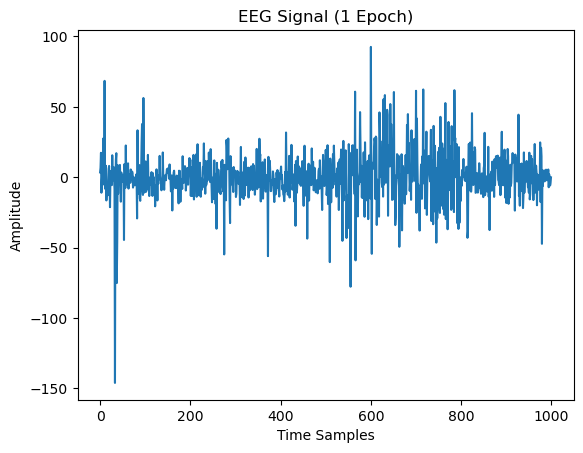

In [237]:
signal = X_test[0]

# Plot it
plt.plot(signal)
plt.title("EEG Signal (1 Epoch)")
plt.xlabel("Time Samples")
plt.ylabel("Amplitude")
plt.show()

### Taking the data from the time domain to the frequency domain

To be able to train machine learning models on this data that is a time series, we should have a predefined vector of features with a fixed length. 

Many approaches exist to do so, the approach we are taking is the frequency domain analysis and this could be done since the sleep cycle exhibits the spectral characteristics.



| Label  | Scientific Term        | Key EEG Features                                                     |
| ----------- | ---------------------- | -------------------------------------------------------------------- |
| **Wake**    | Wakefulness            | High alpha and beta power, low delta.                                |
| **E1 (N1)** | Light sleep stage 1    | Theta power rises, alpha reduces.                                    |
| **E2 (N2)** | Light sleep stage 2    | Theta + sleep spindles (sigma).                                      |
| **E3 (N3)** | Deep sleep (slow-wave) | Dominated by delta power.                                            |
| **REM**     | Dream sleep            | Mixed frequency (theta, some beta), low muscle tone, resembles wake. |


#### 1. Applying the Welch's method:     

This method does the following: 
* Split the signal into non overlapping segments.       
* Apply the Fast Fourier Transform (FFT) for each segment to take the data from the time domain to the frequency domain, and compute the power.       
* Average the power results over each segment and smooth out noise which means it computes the Power Density Function (PSD).     


***Note:***    

Based on the litterature the EEG Frequency the bands are as follows:  

- Delta: from 0.5 Hz to 4 Hz    -->  Deep sleep
- Theta: from 4 Hz to 8 Hz  -->  Light sleep   
- Alpha: from 8 Hz to 12 Hz     -->  Relaxed    
- Sigma: from 12 Hz to 16 H     -->  Sleep spind (bursts of neural oscillatory activity)    
- Beta: from 16 Hz to 30 Hz     -->  Thinking/ alert    
- Gamma: from 30 Hz to 45 H     -->  High level cognitive processes       

In [238]:
bands = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 12),
    'sigma': (12, 16),
    'beta': (16, 30),
    'gamma': (30, 45)
}

In [239]:
sampling_freq = 10

def extract_features(signal):
    freq, power_spectral_density = welch(signal, fs= sampling_freq, nperseg= sampling_freq*2) #use two seconds segments

    total_power = np.trapz(power_spectral_density, freq)

    features = {}

    #extracting the features from the freq and their power
    for band_name, (low, high) in bands.items():
        idx_band = np.logical_and(freq >= low, freq <= high)
        band_power = np.trapz(power_spectral_density[idx_band], freq[idx_band])
        features[f"{band_name}_power"] = band_power
        features[f"relative_{band_name}"] = band_power / total_power
    
    #ratio features
    """Delta/Theta ratio used to differentiate between the deep sleep and the light sleep"""
    features["delta_theta_ratio"]= features["delta_power"] / (features["theta_power"] + 1e-10)  #add the small value to avoid div by 0 problem 

    """Theta/ Alpha ratio used to see how much sleep is present compared to alert in the signal"""
    features["theta_alpha_ratio"]= features["theta_power"] / (features["alpha_power"] + 1e-10)  #add the small value to avoid div by 0 problem 


    #spectral edge frequency (threshold = 90%)
    """This is used to see if the brain activity are dominated by slow waves or high frequency waves"""
    cumulative_power = np.cumsum(power_spectral_density)
    spectral_edge_frequency = freq[np.where(cumulative_power >= 0.9 * cumulative_power[-1])[0][0]]
    features["spectral_edge"] = spectral_edge_frequency


    #spindle density
    """Useful to predict the second stage of sleep"""
    features["spindle_density"] = features["sigma_power"]


    #spectral entropy
    """" This is useful to predict some classes for example the REM has high entropy, the E3 has low entropy """
    power_spectral_density_normalized = power_spectral_density/ np.sum(power_spectral_density)
    spectral_entropy = -np.sum(np.log2(power_spectral_density_normalized + 1e-10) *power_spectral_density_normalized)
    features["spectral_entropy"] = spectral_entropy

    spectral_flux = np.sum(np.diff(power_spectral_density)**2)
    features["spectral_flux"] = spectral_flux

    peak_frequency = freq[np.argmax(power_spectral_density)]
    features["peak_frequency"] = peak_frequency

    peak_to_peak = np.max(signal) - np.min(signal)
    features["peak_to_peak"] = peak_to_peak

    #Statistical information (time domain specific)
    features["mean"] = np.mean(signal)
    features["std"] = np.std(signal)
    features["var"] = np.var(signal)
    features["median"] = np.median(signal)
    features["min"] = np.min(signal)
    features["max"] = np.max(signal)
    features["skewness"] = skew(signal)
    features["kurtosis"] = kurtosis(signal)

    return features


Extracting the features for the train set

In [240]:
feature_list = []
for signal in np.array(X_train):
    features = extract_features(signal)
    feature_list.append(features)

X_train_features = feature_list
print(X_train_features)

[{'delta_power': 55.455199218706284, 'relative_delta': 0.7614158262901409, 'theta_power': 5.233743566339298, 'relative_theta': 0.07186080364509262, 'alpha_power': 0.0, 'relative_alpha': 0.0, 'sigma_power': 0.0, 'relative_sigma': 0.0, 'beta_power': 0.0, 'relative_beta': 0.0, 'gamma_power': 0.0, 'relative_gamma': 0.0, 'delta_theta_ratio': 10.595704301277877, 'theta_alpha_ratio': 52337435663.392975, 'spectral_edge': 3.5, 'spindle_density': 0.0, 'spectral_entropy': 2.851324223667626, 'spectral_flux': 1618.7575173059447, 'peak_frequency': 0.5, 'peak_to_peak': 55.55165099999999, 'mean': -0.16849815084269645, 'std': 8.932471730724357, 'var': 79.78905122018978, 'median': 0.17387058, 'min': -35.773872, 'max': 19.777779, 'skewness': -0.4156538134464829, 'kurtosis': 0.7371787461456765}, {'delta_power': 31.166571838111324, 'relative_delta': 0.733203045913657, 'theta_power': 5.234709554007356, 'relative_theta': 0.12314812836675788, 'alpha_power': 0.0, 'relative_alpha': 0.0, 'sigma_power': 0.0, 'rel

Extracting the features for the test set

In [241]:
feature_list = []
for signal in np.array(X_test):
    features = extract_features(signal)
    feature_list.append(features)

X_test_features = feature_list

### Feature selection

This step is a crutial step, because of the number of features that is high the model can suffer from the curse of dimensionality   
By selecting the features, we reduce the model complexity and reduce the overfitting    

The algorithm chosen for this step is: **Mutual information**  
This aims to measure how much information a feature gives about the target.

In [242]:
X_train_features[0]

{'delta_power': 55.455199218706284,
 'relative_delta': 0.7614158262901409,
 'theta_power': 5.233743566339298,
 'relative_theta': 0.07186080364509262,
 'alpha_power': 0.0,
 'relative_alpha': 0.0,
 'sigma_power': 0.0,
 'relative_sigma': 0.0,
 'beta_power': 0.0,
 'relative_beta': 0.0,
 'gamma_power': 0.0,
 'relative_gamma': 0.0,
 'delta_theta_ratio': 10.595704301277877,
 'theta_alpha_ratio': 52337435663.392975,
 'spectral_edge': 3.5,
 'spindle_density': 0.0,
 'spectral_entropy': 2.851324223667626,
 'spectral_flux': 1618.7575173059447,
 'peak_frequency': 0.5,
 'peak_to_peak': 55.55165099999999,
 'mean': -0.16849815084269645,
 'std': 8.932471730724357,
 'var': 79.78905122018978,
 'median': 0.17387058,
 'min': -35.773872,
 'max': 19.777779,
 'skewness': -0.4156538134464829,
 'kurtosis': 0.7371787461456765}

In [243]:
X_train_features_df = pd.DataFrame(X_train_features)
X_test_features_df = pd.DataFrame(X_test_features)

In [244]:
selector = SelectKBest(score_func=mutual_info_classif, k='all')
selector.fit(X_train_features_df, y_train)

scores = selector.scores_
feature_scores = pd.DataFrame({'Feature': X_train_features_df.columns, 'Score': scores})
feature_scores = feature_scores.sort_values(by='Score', ascending=False)

print(feature_scores)

              Feature     Score
21                std  0.341692
22                var  0.341578
19       peak_to_peak  0.320414
24                min  0.294347
25                max  0.282323
17      spectral_flux  0.279145
0         delta_power  0.270108
12  delta_theta_ratio  0.249717
3      relative_theta  0.248245
16   spectral_entropy  0.236509
14      spectral_edge  0.234478
1      relative_delta  0.164605
13  theta_alpha_ratio  0.121904
2         theta_power  0.121904
18     peak_frequency  0.105890
23             median  0.099202
27           kurtosis  0.064120
20               mean  0.029446
26           skewness  0.012201
5      relative_alpha  0.006099
7      relative_sigma  0.002293
6         sigma_power  0.000000
10        gamma_power  0.000000
8          beta_power  0.000000
4         alpha_power  0.000000
9       relative_beta  0.000000
15    spindle_density  0.000000
11     relative_gamma  0.000000


Based on this ranking let's take the top 15 features 

In [252]:
select = SelectKBest(score_func=mutual_info_classif, k=15)

X_train_selected = select.fit_transform(X_train_features_df, y_train)
X_test_selected = select.transform(X_test_features_df)


X_train_selected_df = pd.DataFrame(X_train_selected, columns=X_train_features_df.columns[select.get_support()])
X_test_selected_df = pd.DataFrame(X_test_selected, columns=X_train_features_df.columns[select.get_support()])

print("The new extracted train shape: ", X_train_selected_df.shape)
print("The new extracted train: \n", X_train_selected_df.head())

print("")
print("__"*50)
print("")

print("The new extracted test: ",X_test_selected_df.shape)
print("The new extracted test: ",X_test_selected_df.head())

The new extracted train shape:  (4999, 15)
The new extracted train: 
    delta_power  relative_delta  theta_power  relative_theta  \
0    55.455199        0.761416     5.233744        0.071861   
1    31.166572        0.733203     5.234710        0.123148   
2    33.247795        0.739160     3.423835        0.076118   
3    34.072803        0.752383     6.559930        0.144854   
4    27.964850        0.756874     4.369355        0.118257   

   delta_theta_ratio  theta_alpha_ratio  spectral_edge  spectral_entropy  \
0          10.595704       5.233744e+10            3.5          2.851324   
1           5.953830       5.234710e+10            4.5          3.018035   
2           9.710688       3.423835e+10            4.0          2.678772   
3           5.194080       6.559930e+10            4.5          3.214949   
4           6.400224       4.369355e+10            4.5          3.285531   

   spectral_flux  peak_to_peak       std        var    median        min  \
0    1618.757517  

In [253]:
X_train = X_train_selected_df
y_train = y_train

X_test = X_test_selected_df


from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [254]:
X_train = X_train_scaled
X_test = X_test_scaled

# Training

#### Imports

In [255]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from skopt import BayesSearchCV

## Decision Trees

In [256]:
model = DecisionTreeClassifier(random_state=42)

model.fit(X_train, y_train)

prediction = model.predict(X_test)
scores = cross_val_score(model, X_train, y_train, cv=5)
print(scores.mean())

0.4911025025025024


#### Hyperparameter tuning using bayesian search

In [257]:
search_space = {
    'max_depth': (1, 30),  # range for max depth of trees
    'min_samples_split': (2, 10),  # range for min samples to split
    'min_samples_leaf': (1, 10),  # range for min samples to be in a leaf
    'criterion': ['gini', 'entropy']  
}

In [258]:
bayesian_search = BayesSearchCV(
    model,
    search_space,
    n_iter=10,  # Number of iterations for the optimization
    scoring='accuracy',  # Metric for evaluation
    cv=5,  # Cross-validation folds
    random_state=42
)

bayesian_search.fit(X_train, y_train)
print("Best parameters found: ", bayesian_search.best_params_)
print("Best cross-validation score: {:.4f}".format(bayesian_search.best_score_))


y_pred = bayesian_search.predict(X_test)

Best parameters found:  OrderedDict({'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 6, 'min_samples_split': 8})
Best cross-validation score: 0.5419
